## Author: Muhammad

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pycaret.regression import *

**Data Source:** Census Bureau America Community Survery 2018, 5 Year Estimates, [hosted on Google BigQuery](https://console.cloud.google.com/marketplace/product/united-states-census-bureau/acs?filter=solution-type:dataset&project=covid-disparities&organizationId=0)

In [ ]:
acs = pd.read_csv("../data/ACS/acs_census_tract_2018_5yr.csv")
acs.drop(columns=["Unnamed: 0", "do_date"], inplace=True)

## Feature Engineering for ACS Variables

In [ ]:
# Filtering columns which contain population numbers
male_female_columns = [x for x in acs.columns 
                    if "male_" in x and 
                    x not in ['male_male_households', 'female_female_households','children_in_single_female_hh']
]
pop_columns = [x for x in acs.columns if "pop" in x] + male_female_columns

### Aggregating Various Variables

In [ ]:
# Create 4 new SVI variables from ACS variables 
acs['aged_65_or_older'] = acs['female_65_to_66'] + acs['female_67_to_69'] + acs['female_70_to_74'] + acs['female_75_to_79'] + acs['female_80_to_84'] + acs['female_85_and_over'] + acs['male_65_to_66'] + acs['male_67_to_69'] + acs['male_70_to_74'] + acs['male_75_to_79'] + acs['male_80_to_84'] + acs['male_85_and_over']
acs['aged_17_or_younger'] = acs['female_under_5'] + acs['female_5_to_9'] + acs['female_10_to_14'] + acs['female_15_to_17'] + acs['male_under_5'] + acs['male_5_to_9'] + acs['male_10_to_14'] + acs['male_15_to_17']
acs['multi_unit_structures'] = acs['dwellings_10_to_19_units'] + acs['dwellings_20_to_49_units'] + acs['dwellings_50_or_more_units']

# Non-white
acs['non_white'] = acs['total_pop'] - acs['white_pop']

In [ ]:
# Function for converting percentile bins into categories
def perc_bin(x):
    
    if x > 0 and x <= 0.1:
      val = 1
    elif x > 0.1 and x <= 0.2:
      val = 2
    elif x > 0.2 and x <= 0.3:
      val = 3
    elif x > 0.3 and x <= 0.4:
      val = 4
    elif x > 0.4 and x <= 0.5:
      val = 5
    elif x > 0.5 and x <= 0.6:
      val = 6
    elif x > 0.6 and x <= 0.7:
      val = 7
    elif x > 0.7 and x <= 0.8:
      val = 8
    elif x > 0.8 and x <= 0.9:
      val = 9
    elif x > 0.9 and x <= 1:
      val = 10
    else:
      val = 0

    return val

In [ ]:
# Aggregating variables and normalising them
acs['poverty_perc'] = acs['poverty']/acs['pop_determined_poverty_status']
# acs['poverty_perc_bin'] = acs['poverty_perc'].apply(perc_bin)

acs['unemployed_pop_perc'] = acs['unemployed_pop'] / acs['total_pop']
# acs['unemployed_pop_perc_bin'] = acs['unemployed_pop_perc'].apply(perc_bin)

acs['less_than_high_school_graduate_perc'] = acs['less_than_high_school_graduate'] / acs['total_pop']
# acs['less_than_high_school_graduate_perc_bin'] = acs['less_than_high_school_graduate_perc'].apply(perc_bin)

acs['aged_65_or_older_perc'] = acs['aged_65_or_older'] / acs['total_pop']
# acs['aged_65_or_older_perc_bin'] = acs['aged_65_or_older_perc'].apply(perc_bin)

acs['aged_17_or_younger_perc'] = acs['aged_17_or_younger'] / acs['total_pop']
# acs['aged_17_or_younger_perc_bin'] = acs['aged_17_or_younger_perc'].apply(perc_bin)

acs['one_parent_families_with_young_children_perc'] = acs['one_parent_families_with_young_children'] / acs['households']
# acs['one_parent_families_with_young_children_perc_bin'] = acs['one_parent_families_with_young_children_perc'].apply(perc_bin)

acs['non_white_perc'] = acs['non_white'] / acs['total_pop']
# acs['non_white_perc_bin'] = acs['non_white_perc'].apply(perc_bin)

acs['multi_unit_structures_perc'] = acs['multi_unit_structures'] / acs['housing_units']
# acs['multi_unit_structures_perc_bin'] = acs['multi_unit_structures_perc'].apply(perc_bin)

acs['mobile_homes_perc'] = acs['mobile_homes'] / acs['housing_units']
# acs['mobile_homes_perc_bin'] = acs['mobile_homes_perc'].apply(perc_bin)

acs['no_cars_perc'] = acs['no_cars'] / acs['households']
# acs['no_cars_perc_bin'] = acs['no_cars_perc'].apply(perc_bin)

acs['group_quarters_perc'] = acs['group_quarters'] / acs['total_pop']
# acs['group_quarters_perc_bin'] = acs['group_quarters_perc'].apply(perc_bin)

In [ ]:
# Dropping all the columns whose data has been aggregated or normalised
acs.drop(columns=
    [
        'female_65_to_66', 'female_67_to_69', 'female_70_to_74', 'female_75_to_79', 'female_80_to_84', 
        'female_85_and_over','male_65_to_66', 'male_67_to_69', 'male_70_to_74', 'male_75_to_79', 
        'male_80_to_84', 'male_85_and_over', 'poverty', 'pop_determined_poverty_status','unemployed_pop', 
        'less_than_high_school_graduate', 'aged_65_or_older', 'aged_17_or_younger', 
        'one_parent_families_with_young_children', 'non_white', 'multi_unit_structures', 'mobile_homes', 
        'no_cars', 'group_quarters', 
    ], inplace=True)

In [ ]:
# Other Races in the Original Data is overriden by other_races_pop = total_pop - sum(races),
# where races is shown below.
races = ['black_pop',
 'asian_pop',
 'hispanic_pop',
 'amerindian_pop',
 'white_pop']
acs['other_race_pop_perc'] = (acs.total_pop - acs[races].sum(axis=1)) / acs.total_pop

# Normalising racial populations by total_pop
acs['black_pop_perc'] = acs.black_pop / acs.total_pop
acs['asian_pop_perc'] = acs.asian_pop / acs.total_pop
acs['hispanic_pop_perc'] = acs.hispanic_pop / acs.total_pop
acs['amerindian_pop_perc'] = acs.amerindian_pop / acs.total_pop
acs['white_pop_perc'] = acs.white_pop / acs.total_pop

# Dropping raw populations in favour of normalised percentages
acs.drop(columns=['two_or_more_races_pop'] + races, inplace=True)

## Geo (Redlining) Data

In [ ]:
# Reading the goe_files for each city.
geo_files = [
"../data/dallas/dallas_redlined_numerical_values.geojson",
"../data/detroit/detroit_redlined_numerical_values.geojson",
"../data/new york/ny_redlined_numerical_values.geojson",
"../data/minneapolis/minneapolis_redlined_numerical_values.geojson",
"../data/california/cali_redlined_numerical_values.geojson",
"../data/boston/boston_redlined_numerical_values.geojson",
"../data/tampa/tampa_redlined_numerical_values.geojson",
"../data/newark/newark_redlined_numerical_values.geojson",
"../data/chicago/chicago_redlined_numerical_values.geojson",
"../data/atlanta/atlanta_redlined_numerical_values.geojson",
]

dfs = [gpd.read_file(x) for x in geo_files]

In [ ]:
# Shows the number of rows per city
num_rows = [len(x) for x in dfs]
city_names = [x.split("_", 1)[0].split("/")[-1] for x in geo_files]
# Number of data points for each city
for x in zip(city_names, num_rows):
    print(x)

('dallas', 122)
('detroit', 573)
('ny', 2122)
('minneapolis', 124)
('cali', 2146)
('boston', 196)
('tampa', 60)
('newark', 224)
('chicago', 1033)
('atlanta', 135)


In [ ]:
# Rounding off the reweighted_redline_index to 2 decimal places to reduce spurious variability
# i.e., 3.1111 and 3.1156 are not different enough to be consider very different
geo_intersect = pd.DataFrame(pd.concat(dfs))
geo_intersect = geo_intersect[["GEOID", "reweighted_redline_index","ordinal_value"]]
geo_intersect['reweighted_redline_index'] = geo_intersect['reweighted_redline_index'].round(2)
geo_intersect

,GEOID,reweighted_redline_index,ordinal_value
0,4.811398e+10,3.10,4
1,4.811300e+10,2.09,3
2,4.811301e+10,1.00,1
3,4.811300e+10,2.16,3
4,4.811301e+10,3.00,3
...,...,...,...
130,1.312101e+10,3.00,3
131,1.312101e+10,2.46,3
132,1.312101e+10,2.00,2
133,1.308902e+10,3.00,3


In [ ]:
# A check for catching outliers with respect to the reweighted_redline_index
# np.unique(geo_intersect.reweighted_redline_index, return_counts=True)[0]
geo_intersect[geo_intersect.reweighted_redline_index < 1]

,GEOID,reweighted_redline_index,ordinal_value
258,3.608112e+10,0.16,1
1713,3.608112e+10,0.81,1
1727,3.608113e+10,0.00,1
2,6.037181e+09,0.78,1
231,6.037461e+09,0.56,1
257,6.001405e+09,0.62,1
297,6.037128e+09,0.00,1
750,6.085503e+09,0.63,1
852,6.037128e+09,0.93,1
861,6.037129e+09,0.41,1


# Joining ACS and Redlining Data

In [ ]:
# Merging the geo_files and the ACS data
joined = geo_intersect.merge(acs, how="inner", left_on="GEOID", right_on="geo_id")
joined.drop(columns=["GEOID", "ordinal_value", "geo_id"], inplace=True)

In [ ]:
# Writing the result to file
joined.to_csv("output/acs_feature_data.csv")

In [ ]:
# Number of unique redlining index values
len(np.unique(joined.reweighted_redline_index.values.round(2)))

322

In [ ]:
exp1 = setup(joined, target = "reweighted_redline_index")

,Description,Value
0,session_id,7280
1,Target,reweighted_redline_index
2,Original Data,"(6735, 232)"
3,Missing Values,True
4,Numeric Features,221
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4714, 212)"


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4369,0.3136,0.5597,0.4629,0.1582,0.2252,132.2070
lightgbm,Light Gradient Boosting Machine,0.4425,0.3236,0.5685,0.4460,0.1601,0.2259,4.2990
et,Extra Trees Regressor,0.4566,0.3403,0.5830,0.4174,0.1642,0.2377,20.1140
gbr,Gradient Boosting Regressor,0.4629,0.3493,0.5907,0.4018,0.1666,0.2409,22.3760
rf,Random Forest Regressor,0.4616,0.3496,0.5909,0.4014,0.1664,0.2376,71.6690
xgboost,Extreme Gradient Boosting,0.4638,0.3572,0.5974,0.3879,0.1667,0.2323,173.4430
en,Elastic Net,0.4841,0.3812,0.6169,0.3476,0.1737,0.2491,0.5950
br,Bayesian Ridge,0.4838,0.3813,0.6170,0.3474,0.1730,0.2487,0.1800
lasso,Lasso Regression,0.4872,0.3828,0.6182,0.3449,0.1734,0.2515,0.4080
lr,Linear Regression,0.4874,0.3940,0.6267,0.3254,0.1726,0.2475,0.6700


In [ ]:
cat = create_model("catboost")

IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:37:42
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE


KeyboardInterrupt: 

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f436aef7b38>, plot=summary, feature=None, observation=None)
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


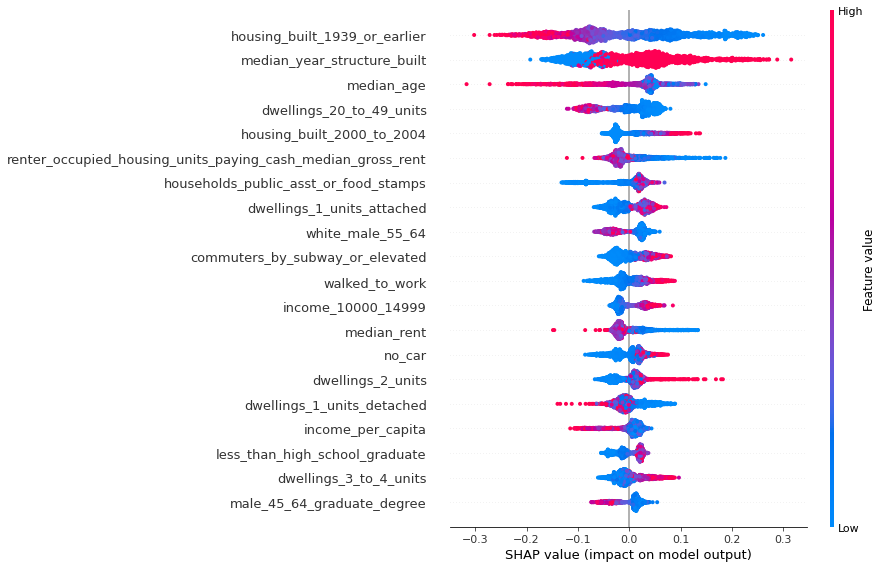

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [ ]:
interpret_model(cat)

# Interpreting Shapley Values

Please see these [four short videos](https://www.coursera.org/lecture/ai-for-medical-treatment/individual-feature-importance-TnfPK) for a better understanding of Shapley values. You will, unfortunately, need to create a Coursera account, because they only let you watch three videos without an account.

In summary, though, each point in the above graph represents a single sample.This is what sets Shapley values apart from 'global' feature importance methods, because it shows you the importance of each feature on a per-sample basis.

The colour of the point shows the value of the feature for that sample. So, for the `median_age` column, a red value means the census tract had a higher median age, while a blue point indicates that the tract had a lower median age.

The x-axis, meanwhile, shows the contribution of that particular feature on the prediction for that particular sample. A positive value on the x-axis indicates a positive contribution toward the predicted value (i.e., an increase in the predicted value) compared to the mean of the overall population, while a negative value on the x-axis indicates a decrease in the predicted value compared to the mean of the overall population. 

This is the *other useful thing* about Shapley values, because **they not only indicate how important a particular feature is, but also what effect a higher/lower feature value has on the prediction** (i.e., does it increase/decrease the predicted value).

Putting it all together, if we consider the `median_age`, what the above graph, with red points being clustered around the left and the blue points clustered around the right, shows is that when a census tract has a higher median age (i.e., red points), this is likely to make the redlining index value of the census tract to decrease.

Note that the way Akash set it up, an index value of 1.0 corresponds to the highest grade (A), while a value of 5.0 corresponds to the lowest grade (E).

As such, the fact that a higher `median_age` corresponds to a lower index value means that **the higher the median age of the census tract, the more likely that it has a good grade (e.g., an A)**, and vice versa.

This could be explained by, perhaps, considering the fact that older people are more likely to be better off economically, and therefore more likely to live in a good neighbourhood, which would result in a better redlining grade. Alternatively, it is sometimes the case that people with lower incomes have more children on average (not sure if this is the case in the U.S., but it is sometimes the case in less developed countries). As such, lower income neighbourhood = more children per capita = lower median age.

These are, of course, just some guesses on my part. The true reason for the correlation would require further research.